In [2]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import json
import requests
from datetime import datetime, timedelta
import calendar
from urllib.parse import urlencode
from collections import OrderedDict
import time
import pickle

In [0]:
MAIN_DIR = Path("drive/My Drive/Colab Notebooks/transformers/Jokes")

DATA_DIR = MAIN_DIR/"data"
DATA_DIR.mkdir(exist_ok=True)
CACHE_FILE = DATA_DIR/'cache.pkl'
DATA_FILE = DATA_DIR/'data.pkl'

In [0]:
# Search parameters
SUBREDDIT = 'Showerthoughts'
AFTER_DT = datetime(2010, 1, 1)
BEFORE_DT = datetime(2020, 1, 1)
SCORE = '>10'

## Download data

In [0]:
def download_submissions_bunch(params):
    """Download the submissions from the subreddit in the selected time range."""
    url = "https://api.pushshift.io/reddit/search/submission/?" + urlencode(params, True)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

In [0]:
def dt2ts(dt):
    """Convert a datetime object to UTC timestamp."""
    return calendar.timegm(dt.utctimetuple())

def ts2dt(ts):
    """Convert a UTC timestamp to a datetime object."""
    return datetime.fromtimestamp(ts)

In [0]:
# Check for correct conversion
assert(ts2dt(dt2ts(datetime(2016, 1, 1))) == datetime(2016, 1, 1))

In [0]:
data = download_submissions_bunch(OrderedDict(
    subreddit=SUBREDDIT,
    after=dt2ts(AFTER_DT),
    before=dt2ts(BEFORE_DT),
    score=SCORE
))

In [67]:
data[0]

{'author': 'drumcowski',
 'author_created_utc': 1302776391,
 'author_flair_css_class': None,
 'author_flair_text': None,
 'author_fullname': 't2_53pjz',
 'created_utc': 1359925769,
 'domain': 'self.Showerthoughts',
 'full_link': 'https://www.reddit.com/r/Showerthoughts/comments/17tqh6/welcome/',
 'gilded': 0,
 'id': '17tqh6',
 'is_self': True,
 'media_embed': {},
 'mod_reports': [],
 'num_comments': 2,
 'over_18': False,
 'permalink': '/r/Showerthoughts/comments/17tqh6/welcome/',
 'retrieved_on': 1413132201,
 'score': 11,
 'secure_media_embed': {},
 'selftext': 'Even though this subreddit has existed for 1 year, we are giving it a reboot today. If you have any questions or suggestions - post them here!\n\n',
 'stickied': False,
 'subreddit': 'Showerthoughts',
 'subreddit_id': 't5_2szyo',
 'thumbnail': 'self',
 'title': 'Welcome',
 'url': 'http://www.reddit.com/r/Showerthoughts/comments/17tqh6/welcome/',
 'user_reports': []}

In [64]:
# Look up the allowed # of requests per minute
!curl -s 'http://api.pushshift.io/meta'

{
    "client_accepts_json": true,
    "client_request_headers": {
        "ACCEPT": "*/*",
        "ACCEPT-ENCODING": "gzip",
        "CDN-LOOP": "cloudflare",
        "CF-CONNECTING-IP": "34.74.208.0",
        "CF-IPCOUNTRY": "US",
        "CF-RAY": "55100d2afe65e3c6-ATL",
        "CF-VISITOR": "{\"scheme\":\"http\"}",
        "CONNECTION": "close",
        "HOST": "api.pushshift.io",
        "USER-AGENT": "curl/7.58.0",
        "X-FORWARDED-FOR": "34.74.208.0, 34.74.208.0",
        "X-FORWARDED-PROTO": "http"
    },
    "client_user_agent": "curl/7.58.0",
    "server_ratelimit_per_minute": 120,
    "source-ip": "34.74.208.0"
}

In [0]:
def download_submissions(subreddit, after_dt, before_dt, **kwargs):
    """Download the whole subreddit by fetching submissions in a loop between two dates."""
    after_ts = dt2ts(after_dt)
    before_ts = dt2ts(before_dt)
    data = []
    total = (before_dt-after_dt).days
    with tqdm(total=total, desc="Days") as pbar:
        while True:
            try:
                query = OrderedDict(
                    subreddit=subreddit,
                    after=after_ts,
                    before=before_ts,
                    fields=['title', 'selftext', 'score', 'num_comments', 'url', 'created_utc'],
                    size=500,
                    **kwargs
                )
                newly_data = download_submissions_bunch(query)
                if len(newly_data) > 0:
                    data.extend(newly_data)
                    after_ts = newly_data[-1]['created_utc']
                    days_passed = (ts2dt(after_ts) - after_dt).days
                    pbar.update(days_passed - pbar.n)
                    time.sleep(0.500) # given 120 per minute allowed
                    if after_ts >= before_ts:
                        break
                else:
                    pbar.update(total - pbar.n) # fill to 100%
                    break
            except BaseException as error:
                print('An exception occurred: {}'.format(error))
                break
    return data

In [69]:
data = download_submissions(SUBREDDIT, AFTER_DT, BEFORE_DT, score=SCORE)

Days: 100%|██████████| 3652/3652 [16:11<00:00,  1.79it/s]


In [0]:
# Save cache data to disk
with open(CACHE_FILE, "wb") as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
# File size
!ls -lh "$CACHE_FILE"

-rw------- 1 root root 108M Jan  6 19:39 'drive/My Drive/Colab Notebooks/transformers/Jokes/data/cache.pkl'


## Prepare data

In [0]:
# Load cache data from disk to avoid re-downloading it
with open(CACHE_FILE, 'rb') as handle:
    data = pickle.load(handle)

In [5]:
df = pd.DataFrame(data)

print(df.shape)
print(df.head())

(434294, 6)
   created_utc  ...                                                url
0   1359925769  ...  http://www.reddit.com/r/Showerthoughts/comment...
1   1359957885  ...  http://www.reddit.com/r/Showerthoughts/comment...
2   1359958683  ...  http://www.reddit.com/r/Showerthoughts/comment...
3   1360003428  ...  http://www.reddit.com/r/Showerthoughts/comment...
4   1360022917  ...  http://www.reddit.com/r/Showerthoughts/comment...

[5 rows x 6 columns]


In [6]:
# Transform UTC timestamp into datetime and assign to index
df['date'] = df['created_utc'].apply(lambda x: pd.datetime.fromtimestamp(x))
df = df.set_index('date')

print(df.index[0])
print(df.index[-1])

2013-02-03 21:09:29
2019-12-29 00:35:00


### Remove invalid or duplicated texts

In [7]:
# Most and least occurring values in titles
df['title'].value_counts()

Nothing is on fire, fire is on things.                                                                          25
Do crabs think fish can fly?                                                                                    25
Nothing is on fire, fire is on things                                                                           21
Brushing your teeth is the only time you clean your skeleton.                                                   21
No one has ever been in an empty room.                                                                          20
                                                                                                                ..
A birth certificate is basically just a receipt for a baby                                                       1
Having to open the door when exiting a public restroom defeats the purpose of washing your hands.                1
Pulling your teeth out and giving them to the tooth fairy for money is the child

In [8]:
# Remove duplicates
print(df.shape)
df = df.drop_duplicates(subset=['title'])
print(df.shape)

(434294, 6)
(428773, 6)


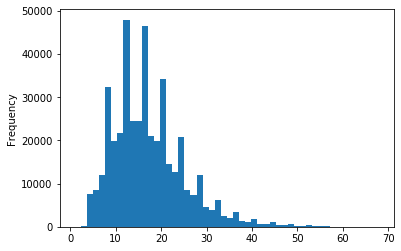

In [9]:
# Number of words in each title
df['title'].apply(lambda x: len(x.split())).plot.hist(bins=50)

In [10]:
# Most and least occurring values in selftexts
df['selftext'].value_counts()

                                                                                                                                                                                                                                                                         356677
[removed]                                                                                                                                                                                                                                                                 24804
[deleted]                                                                                                                                                                                                                                                                  5385
&amp;#x200B;                                                                                                                                                                            

In [11]:
# Filter out selftexts that are non-empty since we expect titles to be self-explanatory
print(df.shape)
df = df[df['selftext'].apply(lambda x: isinstance(x, str) and len(x) == 0)]
print(df.shape)

(428773, 6)
(356677, 6)


In [0]:
# Remove space characters
df['title'] = df['title'].apply(lambda x: ' '.join(x.split()).strip())

### Remove offensive submissions

In [0]:
!pip install profanity-check

     |████████████████████████████████| 2.4MB 2.7MB/s 


In [12]:
from profanity_check import predict, predict_prob

df['profanity'] = [predict_prob([text])[0] for text in tqdm(df['title'])]

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklea

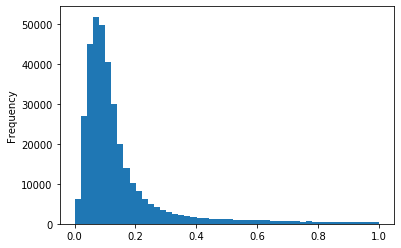

In [13]:
df['profanity'].plot.hist(bins=50)

In [14]:
df.sort_values(by='profanity').iloc[0].to_dict()

{'created_utc': 1554639490,
 'num_comments': 1,
 'profanity': 0.0007551591521797398,
 'score': 11,
 'selftext': '',
 'title': 'When you are a kid you wait for summer vacation and are a pain to your parents, as a teenager your parents don’t really notice when you have summer vacation and as parents there is no summer vacation.',
 'url': 'https://www.reddit.com/r/Showerthoughts/comments/bafola/when_you_are_a_kid_you_wait_for_summer_vacation/'}

In [18]:
df.sort_values(by='profanity').iloc[-1].to_dict()

{'created_utc': 1487999781,
 'num_comments': 50,
 'profanity': 0.9999998932300596,
 'score': 1230,
 'selftext': '',
 'title': 'When I see "wtffffff" I think what the fuuuuuuuuuck instead of what the fuck fuck fuck fuck fuck fuck.',
 'url': 'https://www.reddit.com/r/Showerthoughts/comments/5w2j3i/when_i_see_wtffffff_i_think_what_the_fuuuuuuuuuck/'}

In [19]:
# You can change the threshold to any value you feel to be fair
print(df.shape)
df = df[df['profanity'] < 0.5]
print(df.shape)

(356677, 7)
(340061, 7)


### Keep English submissions only

In [0]:
!pip install langdetect

     |████████████████████████████████| 1.0MB 2.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=1dadedfe91afa1458c64789365bdab998a216db54aa2c0c80bb7979200f275f1
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect


In [20]:
from langdetect import detect

# Detect language
languages = []
for text in tqdm(df['title']):
    try:
        languages.append(detect(text))
    except:
        languages.append(None)
df['language'] = languages

100%|██████████| 340061/340061 [25:07<00:00, 225.65it/s]


In [21]:
df['language'].value_counts()

en    335082
af       995
fr       766
nl       478
no       469
et       339
da       329
ca       283
sv       219
it       171
tl       165
ro       134
cy       115
de        90
es        87
so        63
pt        60
id        44
hu        25
fi        24
hr        15
pl        13
tr        13
lt        12
lv        12
sw        10
sq        10
sk        10
sl         9
cs         6
el         2
ja         1
vi         1
Name: language, dtype: int64

In [40]:
df[df['language'] != 'en'].sample().transpose().to_dict()

{Timestamp('2017-11-09 13:25:32'): {'created_utc': 1510233932,
  'language': 'af',
  'num_comments': 9,
  'profanity': 0.3405414826012277,
  'score': 27,
  'selftext': '',
  'title': 'Most dogs die virgins.',
  'url': 'https://www.reddit.com/r/Showerthoughts/comments/7bt9th/most_dogs_die_virgins/'}}

In [41]:
# Too many false positives but still useful as it hints at problematic sentences
print(df.shape)
df = df[df['language'] == 'en']
print(df.shape)

(340061, 8)
(335082, 8)


## Explore data

### Numeric attributes

In [44]:
df['score'].describe()

count    335082.000000
mean        503.036746
std        3731.792112
min          11.000000
25%          14.000000
50%          23.000000
75%          65.000000
max      143572.000000
Name: score, dtype: float64

In [45]:
# Most scored submission
df.sort_values(by='score', ascending=False).iloc[0].to_dict()

{'created_utc': 1528142598,
 'language': 'en',
 'num_comments': 3575,
 'profanity': 0.06066077384056419,
 'score': 143572,
 'selftext': '',
 'title': 'George Washington died in 1799. The first dinosaur fossil was discovered in 1824. George Washington never knew dinosaurs existed.',
 'url': 'https://www.reddit.com/r/Showerthoughts/comments/8okexh/george_washington_died_in_1799_the_first_dinosaur/'}

In [46]:
df['num_comments'].describe()

count    335082.000000
mean         25.825210
std         134.744346
min           0.000000
25%           3.000000
50%           5.000000
75%          11.000000
max        8014.000000
Name: num_comments, dtype: float64

In [47]:
# Most commented submission
df.sort_values(by='num_comments', ascending=False).iloc[0].to_dict()

{'created_utc': 1568630879,
 'language': 'en',
 'num_comments': 8014,
 'profanity': 0.16178472530591861,
 'score': 118416,
 'selftext': '',
 'title': "Most people know so little that if they were transported 200 years into the past, they wouldn't be able to invent anything any quicker.",
 'url': 'https://www.reddit.com/r/Showerthoughts/comments/d4yxtq/most_people_know_so_little_that_if_they_were/'}

### Creation dates

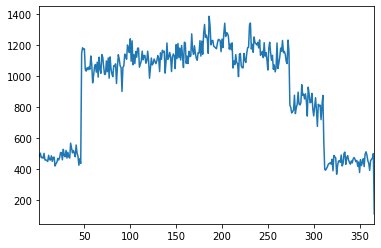

In [48]:
# Submissions by day of year
df.index.dayofyear.value_counts(sort=False).sort_index().plot()

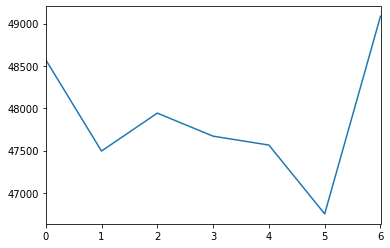

In [51]:
# Submissions by day of week
df.index.dayofweek.value_counts(sort=False).plot()

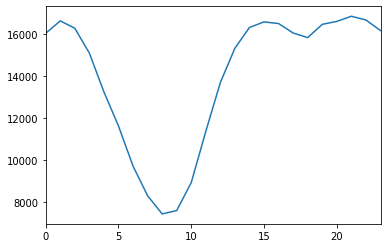

In [52]:
# Submissions by hour of day
df.index.hour.value_counts(sort=False).plot()

### URLs

In [53]:
# How many are third-party links (for example links to images)
df['url'].apply(lambda x: 'www.reddit.com' not in x).sum()

9

In [54]:
df[df['url'].apply(lambda x: 'www.reddit.com' not in x)]['title'].tolist()

['The movie "Skyfall" is basically a James Bond version of "Home Alone"',
 'Do people with multiple personalities have multiple online accounts?',
 'the kim kardashian #breaktheinternet photo looks like that scene in nutty professor where buddy love starts to turn back into sherman klump.',
 "If you were able to actually read people's minds, 80% of the time you'd just hear the song that happens to be stuck in their head",
 'Anna Kendrick’s Take on Shower Thoughts',
 "When's the best time to tell your pet that they're adopted?",
 'Follow r/ShowerThoughts on Twitter, where we share some of our favorite posts each week!',
 "There are a bunch of unofficial Showerthoughts Twitter accounts with WAY more followers than us that don't give you guys any credit - help us catch up by following our official @rShowerthoughts account!",
 'A worm sees the sidewalk like an early explore might have seen the Sahara desert.']

## Export cleaned data

In [0]:
# Save data to the disk
with open(DATA_FILE, "wb") as handle:
    pickle.dump(df['title'].tolist(), handle, protocol=pickle.HIGHEST_PROTOCOL)